In [1]:
import h5py

import fenics as fe
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, "../scripts")

from tqdm import tqdm
from statfenics.utils import build_observation_operator
from swe import ShallowOne
from swe_filter import ShallowOneEx

In [2]:
def extract_components(swe):
    u_out = swe.du.compute_vertex_values()[:(control["nx"] + 1)]
    h_out = swe.du.compute_vertex_values()[(control["nx"] + 1):]
    return u_out, h_out

In [3]:
# setup dynamical systems
control = {"nx": 400, "dt": 4., "theta": 1.0, "simulation": "tidal_flow"}
swe_dgp = ShallowOne(control, 
                     {"nu": 1.})
swe_post = ShallowOneEx(control, 
                        {"nu": 1.}, 
                        {"u_cov": {"rho": 0., "ell": 5000}, "h_cov": {"rho": 1e-2, "ell": 5000}, "k": 32, "k_init": 32}, 
                        lr=True)

# set the observation system

NX = 400
DT = 4.

# set the observation system
t_final = 86_400 / 2  # half a day
nt = np.int64(t_final / DT)
nt_warmup = nt // 4
nt_pred = 100
t_grid = np.arange(nt_warmup * DT, (nt_warmup + nt) * DT, DT)
print(t_grid.shape)

nt_skip = 4
nx_skip = 4
sigma_y = 1e-3

# build obs. operator
x_obs = swe_dgp.x_coords[::nx_skip]  # every 5th location
n_obs = len(x_obs)
H_obs = build_observation_operator(x_obs, swe_post.W, sub=1, out="scipy")

print(f"Warming up for {nt_warmup} iterations")
print(f"Assimilating every {nt_skip} timesteps ({nt_skip * swe_dgp.dt:.3f} s)")
print(f"Observational noise has std. dev. {sigma_y:.4e}")
print(f"Assimilating {H_obs.shape[0]} data points per time")

(10800,)
Warming up for 2700 iterations
Assimilating every 4 timesteps (16.000 s)
Observational noise has std. dev. 1.0000e-03
Assimilating 101 data points per time


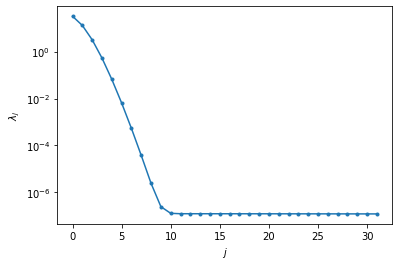

(1202, 32)


In [4]:
plt.semilogy(np.real(swe_post.G_vals), ".-")
plt.xlabel(r'$j$')
plt.ylabel(r'$\lambda_j$')
plt.show()

print(swe_post.G_sqrt.shape)

In [5]:
norm = np.linalg.norm

t = 0.
for i in tqdm(range(nt_warmup)):
    t += swe_post.dt
    swe_dgp.solve(t)

100%|████████████████████████████████████████████████████████████████████| 2700/2700 [00:08<00:00, 302.47it/s]


In [6]:
swe_post.du_prev.vector().set_local(swe_dgp.du_prev.vector().get_local())

norm = np.linalg.norm
var_norm = np.zeros((nt, ))
errors_u = np.zeros((nt, ))
errors_h = np.zeros((nt, ))

for i in tqdm(range(nt)):
    t += swe_post.dt

    swe_dgp.solve(t)
    swe_post.prediction_step(t)
    if i % nt_skip == 0:
        y_obs = swe_dgp.du.compute_vertex_values()[(control["nx"] + 1)::nx_skip]
        y_obs += sigma_y * np.random.normal(size=(n_obs, ))
        swe_post.update_step(y_obs, H_obs, sigma_y)
        
    swe_post.set_prev()
    
    u_true, h_true = extract_components(swe_dgp)
    u_mean, h_mean = extract_components(swe_post)
    errors_u[i] = norm(u_true - u_mean) / norm(u_true)
    errors_h[i] = norm(h_true - h_mean) / norm(h_true)

100%|███████████████████████████████████████████████████████████████████| 10800/10800 [02:06<00:00, 85.62it/s]


In [7]:
print(errors_u[-1])
print(errors_h[-1])

0.0014111212047458563
6.34947515462875e-05


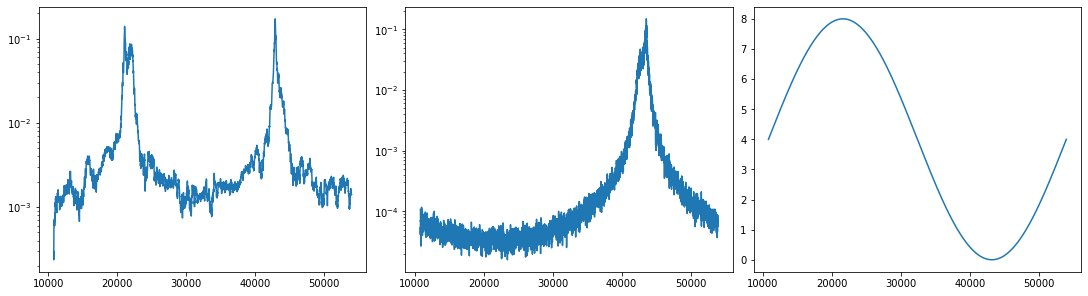

In [10]:
# fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4))

# H_u_verts = build_observation_operator(swe_dgp.x_coords, swe_dgp.W, sub=0)
# H_h_verts = build_observation_operator(swe_dgp.x_coords, swe_dgp.W, sub=1)
# var_u = np.diagonal(H_u_verts @ swe_post.cov @ H_u_verts.T)
# var_h = np.diagonal(H_h_verts @ swe_post.cov @ H_h_verts.T)

# axs[0].plot(swe_dgp.x_coords, u_mean)
# axs[0].fill_between(swe_dgp.x_coords[:, 0], 
#                     u_mean - np.sqrt(var_u), u_mean + np.sqrt(var_u),
#                     alpha=0.2)
# axs[0].plot(swe_dgp.x_coords, u_true)


# axs[1].plot(swe_dgp.x_coords, h_mean)
# axs[1].fill_between(swe_dgp.x_coords[:, 0], 
#                     h_mean - np.sqrt(var_h), h_mean + np.sqrt(var_h),
#                     alpha=0.2)
# axs[1].plot(swe_dgp.x_coords, h_true)
# axs[1].plot(x_obs, y_obs, ".")
# plt.show()

fig, axs = plt.subplots(1, 3, constrained_layout=True, figsize=(15, 4))
axs[0].semilogy(t_grid, errors_u)
axs[1].semilogy(t_grid, errors_h)
axs[2].plot(t_grid, swe_dgp.tidal_bc(t_grid))
plt.show()

# plt.semilogy(var_norm)
# plt.show()

In [11]:
var_norm_pred = np.zeros((nt_pred, ))

for i in range(nt_pred):
    t += swe_post.dt
    swe_dgp.solve(t)
    swe_post.prediction_step(t)
    swe_post.set_prev()
    
    u_true, h_true = extract_components(swe_dgp)
    u_mean, h_mean = extract_components(swe_post)